In [61]:
import warnings

warnings.filterwarnings(
    "ignore",
)
import os

os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np
import scipy

np.set_printoptions(suppress=True)
np.random.seed(1)
import random

random.seed(1)
from typing import Optional

import pandas as pd
from IPython.display import Image
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from statsforecast.arima import ARIMASummary, ndiffs, nsdiffs
from statsforecast.models import ARIMA, AutoARIMA, AutoETS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import kpss
from utilsforecast.losses import mae, rmse, smape

pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
import seaborn as sns
from utilsforecast.plotting import plot_series as plot_series_utils

sns.set_style("whitegrid")
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams.update(
    {
        "figure.figsize": (8, 5),
        "figure.dpi": 100,
        "savefig.dpi": 300,
        "figure.constrained_layout.use": True,
        "axes.titlesize": 12,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "legend.title_fontsize": 10,
    }
)

# Define a harmonious palette (8 colors)
ggplot_palette = [
    "#E24A33",  # orange-red
    "#348ABD",  # blue
    "#988ED5",  # purple
    "#777777",  # gray
    "#FBC15E",  # yellow
    "#8EBA42",  # green
    "#FFB5B8",  # pink
    "#17BECF",  # cyan
]

# Apply the palette globally
sns.set_palette(ggplot_palette)

from functools import partial

import matplotlib as mpl
from fpppy.utils import plot_series
from IPython.display import Image, Markdown, display
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import fourier, pipeline, trend
from utilsforecast.losses import mae
from utilsforecast.losses import mape
from utilsforecast.losses import mape as _mape
from utilsforecast.losses import mase, mqloss, quantile_loss, rmse
from utilsforecast.processing import make_future_dataframe


def mape(df, models, id_col="unique_id", target_col="y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include="number").columns] *= 100
    return df_mape


from fpppy.models import LinearRegression
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.preprocessing import SplineTransformer
from statsforecast import StatsForecast
from statsforecast.models import (
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive,
    SklearnModel,
    WindowAverage,
)
from statsforecast.utils import ConformalIntervals

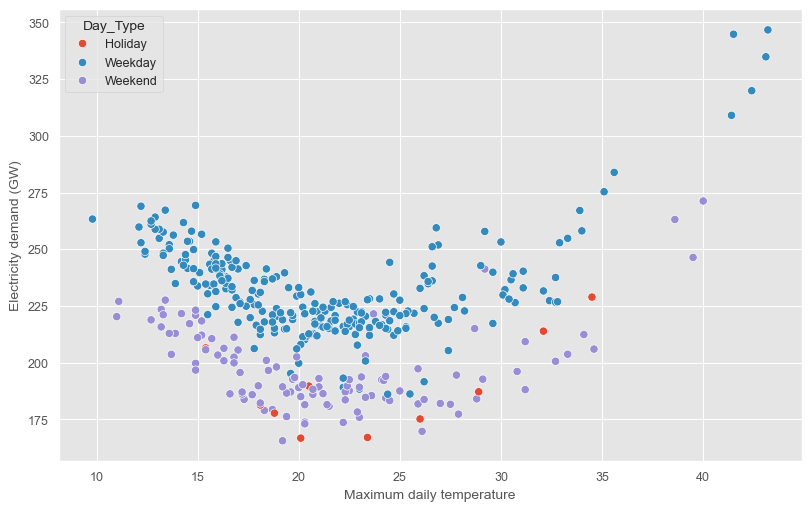

In [50]:
vic_elec = pd.read_csv("../data/vic_elec.csv", parse_dates=["ds"])

vic_elec_df = vic_elec.pivot(index="ds", columns="unique_id", values="y").reset_index()
vic_elec_df = vic_elec_df.merge(vic_elec[["ds", "Holiday"]].drop_duplicates(), on="ds")
vic_elec_df.set_index("ds", inplace=True)

vic_elec_daily = (
    vic_elec_df.resample("D")
    .agg({"Demand": "sum", "Temperature": "max", "Holiday": "first"})
    .reset_index()
)

vic_elec_daily["Demand"] = vic_elec_daily["Demand"] / 1e3
vic_elec_daily.insert(0, "unique_id", "VIC")
vic_elec_daily = vic_elec_daily.query('ds >= "2014-01-01"')
vic_elec_daily["Day_Week"] = vic_elec_daily["ds"].dt.dayofweek

conditions = [
    vic_elec_daily["Holiday"] == True,
    (vic_elec_daily["Holiday"] == False) & (vic_elec_daily["Day_Week"] < 5),
    (vic_elec_daily["Holiday"] == False) & (vic_elec_daily["Day_Week"] >= 5),
]

vic_elec_daily["Day_Type"] = np.select(conditions, ["Holiday", "Weekday", "Weekend"])
vic_elec_daily.drop(columns=["Day_Week"], inplace=True)

plt.figure()
sns.scatterplot(data=vic_elec_daily, x="Temperature", y="Demand", hue="Day_Type")
plt.xlabel("Maximum daily temperature")
plt.ylabel("Electricity demand (GW)")
plt.show()

In [55]:
vic_elec_daily["Temperature2"] = (vic_elec_daily["Temperature"] >= 25).astype(int)

sf = StatsForecast(
    models=[AutoARIMA(season_length=7)],
    freq="D",
)

vic_elec_daily_ex = vic_elec_daily[
    ["unique_id", "ds", "Demand", "Temperature", "Temperature2"]
]
vic_elec_daily_ex["Weekday"] = vic_elec_daily["Day_Type"] == "Weekday"
vic_elec_daily_ex["Temperature**2"] = vic_elec_daily_ex["Temperature"] ** 2
sf = sf.fit(
    df=vic_elec_daily_ex,
    target_col="Demand",
)

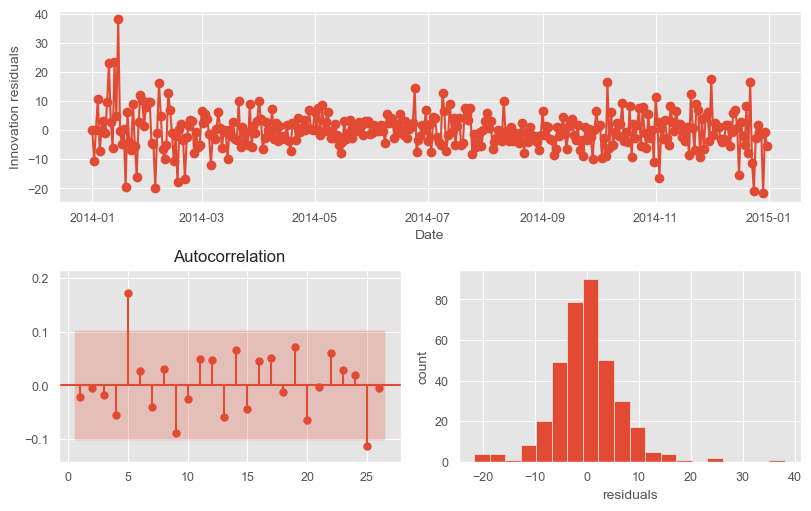

In [57]:
resids = sf.fitted_[0, 0].model_["residuals"]
fig = plt.figure()

gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.plot(vic_elec_daily["ds"], resids, marker="o")
ax1.set_ylabel("Innovation residuals")
ax1.set_xlabel("Date")

plot_acf(resids, ax2, zero=False, auto_ylims=True, bartlett_confint=False)

ax3.hist(resids, bins=20)
ax3.set_ylabel("count")
ax3.set_xlabel("residuals")

plt.show()

In [58]:
print(ARIMASummary(sf.fitted_[0, 0].model_))
print(f"Coefficients: {sf.fitted_[0, 0].model_['coef']}")
print(f"sigma^2     : {sf.fitted_[0, 0].model_['sigma2']:.2f}")
print(f"loglik      : {sf.fitted_[0, 0].model_['loglik']:.2f}")
print(f"aic         : {sf.fitted_[0, 0].model_['aic']:.2f}")
print(f"aicc        : {sf.fitted_[0, 0].model_['aicc']:.2f}")
print(f"bic         : {sf.fitted_[0, 0].model_['bic']:.2f}")

Regression with ARIMA(2,1,2)(2,0,2)[7] errors
Coefficients: {'ar1': -0.08512657479213956, 'ar2': 0.7148751205480366, 'ma1': -0.02515917171381157, 'ma2': -0.9119632425019105, 'sar1': 0.3091167046777454, 'sar2': 0.5668163083292574, 'sma1': -0.1637431784452573, 'sma2': -0.38952304164651486, 'ex_1': -7.516988367976649, 'ex_2': 0.4894128632507322, 'ex_3': 29.31708493271822, 'ex_4': 0.17725805455706153}
sigma^2     : 43.16
loglik      : -1197.28
aic         : 2420.56
aicc        : 2421.60
bic         : 2471.22


In [59]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box = acorr_ljungbox(resids, lags=[14], model_df=6)

ljung_box

,lb_stat,lb_pvalue
14,21.647,0.006


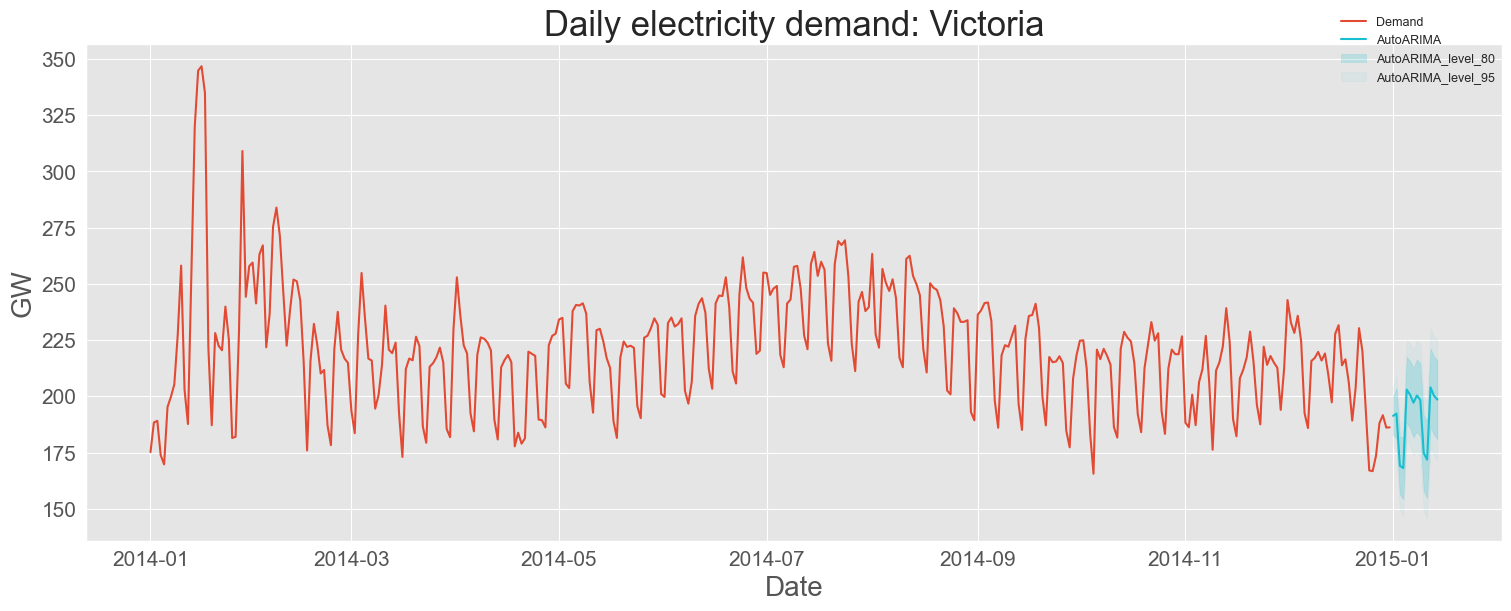

In [63]:
future_predictors = make_future_dataframe(
    vic_elec_daily_ex["unique_id"].unique(),
    pd.to_datetime([vic_elec_daily_ex["ds"].max()]),
    freq="D",
    h=14,
)
future_predictors["Temperature"] = 26
future_predictors["Temperature2"] = 1
future_predictors["Weekday"] = ~future_predictors["ds"].dt.dayofweek.isin([5, 6])
future_predictors["Temperature**2"] = 26**2

fc = sf.predict(h=14, X_df=future_predictors, level=[80, 95])
plot_series(
    vic_elec_daily_ex,
    fc,
    target_col="Demand",
    level=[80, 95],
    xlabel="Date",
    ylabel="GW",
    title="Daily electricity demand: Victoria",
    rm_legend=False,
)